## Project: Estimation of accuracy of MOI for MVCs 
Created by: Thomas Hartka, MD, MSDS  
Date created: 1/27/22  
  
This notebook analyzes determines the sensitivity, specificity, and accuracy of the CDC MOI criteria for MVC in  patients in different age groups.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scipy.stats as st
import matplotlib.pyplot as plt
from itertools import combinations
import datetime
from multiprocessing import Process, Queue
import multiprocessing
import moi_analysis as moi

## Parameters

In [2]:
mvcs_data_file = "../Data/NASS_CISS-2000_2019-unfiltered.csv"
mvcs_imp_data_file = "../Data/NASS_CISS-2000_2019-imputated.csv"

In [3]:
use_imputed = True  # whether to use imputed or raw data
bootstrap_div = 5   # divisor of full sample len for bootstrapped sample
bootstrap_num = 1000   # number of bootstrapped samples

In [4]:
# column names
outcome = 'iss16'
existing_cit = ['int12occ','int18','ejection','other_death']
case_weights = 'casewgt'

## Read in data

In [5]:
if use_imputed:
    # use imputated data set
    mvcs = pd.read_csv(mvcs_imp_data_file)

else:
    # use unimputed data set
    mvcs = pd.read_csv(mvcs_data_file)

## Function for bootstrap evaluation of criteria

In [6]:
def bootstrap_list(dat, predictors, response, sample_size, bs_num, sig_dig=-1, verbose=False):
    '''
    This function runs bootstrapped acc, sens, and spec calculations.  It then finds the 
    median with 95% CI and returns the results as a  list.
    
    Parameters:
        dat - data to analyze
        predictors - list of columns for predictors
        response - outcome column
        sample_size - size of bootstrapped sample
        bs_num - number of bootstrap iterations
    Returns:
        list - (accuracy med, 95% LL, 95% UL, sensitivity med, 95% LL, 95% UL, specificity med, 95% LL, 95% UL)
    '''
    
    # lists for results
    acc = []
    sens = []
    spec = []
    
    for i in range(0,bs_num):
        # sample with replacement
        sample = dat.sample(sample_size, replace=True)

        # calculate AUC
        res = moi.var_perf(sample, predictors, response, 'casewgt')

        if verbose:
            if (i%100==0):
                print("Sample: ", i, " of ", bs_num)
        
        # store results to list
        acc += [res.accuracy]
        sens += [res.sensitivity]
        spec += [res.specificity]
        
    # get summary statistics
    acc_sum = moi.med_ci(acc, sig_dig=sig_dig)
    sens_sum = moi.med_ci(sens, sig_dig=sig_dig)
    spec_sum = moi.med_ci(spec, sig_dig=sig_dig)
    
    # convert to list
    results = [acc_sum[0], acc_sum[1][0], acc_sum[1][1], \
               sens_sum[0], sens_sum[1][0], sens_sum[1][1], \
               spec_sum[0], spec_sum[1][0], spec_sum[1][1]]
    
    return results

In [7]:
def age_analysis(dat, ages, predictors, response, bs_num, sig_dig=-1, verbose=False):
    '''
    This script determines the acc, sens, and spec of MOI criteria for different age groups and 
     returns a data frame with the results.
     
    Parameters:
        dat - data to analyze
        age - list with lower and upper limits for age (inclusive)
        predictors - list of columns for predictors
        response - outcome column
        bs_num - number of bootstrap iterations
    Returns:
        list - (accuracy med, 95% LL, 95% UL, sensitivity med, 95% LL, 95% UL, specificity med, 95% LL, 95% UL)    
    '''
    
    # filter data for ages
    dat = dat[(dat.age>=ages[0]) & (dat.age<=ages[1])]
    
    # calculate bootstrap sample size
    sample_size = round(len(dat)/bootstrap_div)
    
    # get performance for age group
    res = bootstrap_list(dat, predictors, response, sample_size, bs_num, sig_dig=-1, verbose=verbose)
    
    # create dataframe for results
    res_df = pd.DataFrame({'ages':str(ages[0])+"-"+str(ages[1]), \
                           'acc_med':[res[0]], \
                           'acc_ll':[res[1]], \
                           'acc_ul':[res[2]], \
                           'sens_med':[res[3]], \
                           'sens_ll':[res[4]], \
                           'sens_ul':[res[5]], \
                           'spec_med':[res[6]], \
                           'spec_ll':[res[7]], \
                           'spec_ul':[res[8]]})
    
    return res_df

## Calculate performance for different age groups

In [37]:
%%time
# data frame for results from current critieria
results = pd.DataFrame()

# get results for age groups
results = results.append(age_analysis(mvcs, [0,18], existing_cit, outcome, bootstrap_num, sig_dig=2, verbose=False))
results = results.append(age_analysis(mvcs, [19,54], existing_cit, outcome, bootstrap_num, sig_dig=2, verbose=False))
results = results.append(age_analysis(mvcs, [55,100], existing_cit, outcome, bootstrap_num, sig_dig=2, verbose=False))
results = results.append(age_analysis(mvcs, [65,100], existing_cit, outcome, bootstrap_num, sig_dig=2, verbose=False))

display(results)

,ages,acc_med,acc_ll,acc_ul,sens_med,sens_ll,sens_ul,spec_med,spec_ll,spec_ul
0,0-18,0.968499,0.965051,0.971868,0.628817,0.552311,0.698331,0.972341,0.968950,0.975479
0,19-54,0.966315,0.963529,0.968718,0.593657,0.568728,0.617313,0.972472,0.969703,0.974815
0,55-100,0.964871,0.959989,0.969010,0.410215,0.368149,0.448838,0.983535,0.979730,0.986595
0,65-100,0.957927,0.949726,0.964147,0.357559,0.307363,0.406275,0.983170,0.977298,0.987257


CPU times: user 3min 36s, sys: 17.2 s, total: 3min 53s
Wall time: 3min 41s


In [36]:
1-0.357/0.628

0.43152866242038224

## Plot results

In [40]:
results['ages'] = results.ages.str.replace('-100','+') + " years"

results = results.set_index('ages')

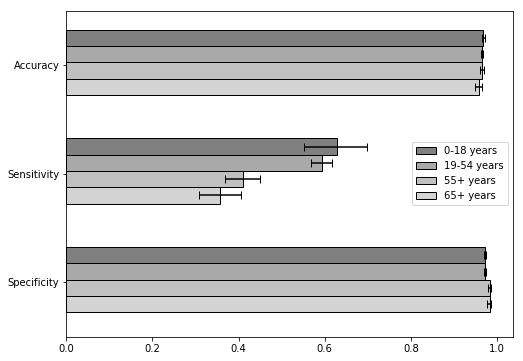

In [41]:
# number of age categories
age_cats = len(results)

# height of the bars
bar_hgt = 0.6/age_cats
 
# initial position of bars 
init_pos = np.arange(3)-0.25

colors = ['grey','darkgrey','silver','lightgrey']
 
ax = plt.figure(0)
    
for i in range(0, age_cats):
    bar = results.iloc[i][['acc_med','sens_med','spec_med']].values
    
    #y_pos = [y + bar_hgt*(age_cats-i) for y in init_pos]
    y_pos = [y + bar_hgt*i for y in init_pos]
    
    x_err = [[results.acc_med.iloc[i]-results.acc_ll.iloc[i], results.sens_med.iloc[i]-results.sens_ll.iloc[i], results.spec_med.iloc[i]-results.spec_ll.iloc[i]], \
             [results.acc_ul.iloc[i]-results.acc_med.iloc[i], results.sens_ul.iloc[i]-results.sens_med.iloc[i], results.spec_ul.iloc[i]- results.spec_med.iloc[i]]]
    
    plt.barh(y_pos, bar, height = bar_hgt, color = colors[i], xerr = x_err, capsize=4, edgecolor = 'black', label=results.index[i])
    
plt.yticks((0, 1, 2), ('Accuracy', 'Sensitivity', 'Specificity'))

plt.ylim(2.5,-0.5)

ax.set_size_inches(8,6)

plt.legend()